In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
df_yield = pd.read_csv("data/barley_yield_from_1982.csv", sep=";")
df_yield.drop(columns=["Unnamed: 0"], inplace=True)
df_climate = pd.read_parquet("data/climate_data_from_1982.parquet")

# Climate Data Frame


In [86]:
# Raw Dataframe
df_climate

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,2.762923e+02
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,2.750924e+02
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,2.764185e+02
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,2.788934e+02
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,2.788872e+02
...,...,...,...,...,...,...,...
1170256,ssp5_8_5,Yvelines,78,2050-12-27 12:00:00,2050,precipitation,3.356686e-05
1170257,ssp5_8_5,Yvelines,78,2050-12-28 12:00:00,2050,precipitation,3.531645e-06
1170258,ssp5_8_5,Yvelines,78,2050-12-29 12:00:00,2050,precipitation,4.072561e-06
1170259,ssp5_8_5,Yvelines,78,2050-12-30 12:00:00,2050,precipitation,4.087608e-09


In [87]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13540116 entries, 29950 to 1170260
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   scenario  object        
 1   nom_dep   object        
 2   code_dep  object        
 3   time      datetime64[ns]
 4   year      int32         
 5   metric    object        
 6   value     float32       
dtypes: datetime64[ns](1), float32(1), int32(1), object(4)
memory usage: 723.1+ MB


#### Data cleaning


Check for missing values before pivoting


In [88]:
df_climate.isna().sum()

scenario    0
nom_dep     0
code_dep    0
time        0
year        0
metric      0
value       0
dtype: int64

In [90]:
# We have different scenarios for the future
scenarios = df_climate["scenario"].unique()
print(f"Scenarios : {scenarios}")
for scenario in scenarios:
    years = df_climate[df_climate["scenario"] == scenario]["year"].unique()
    print(f"- {scenario} data : {years[0]} to {years[-1]}")

# We decide to keep only the data from 1982 to 2030 as we consider climate forecast from 2030 to 2050 too uncertain.
df_climate = df_climate[df_climate["year"] <= 2030]

Scenarios : ['historical' 'ssp1_2_6' 'ssp2_4_5' 'ssp5_8_5']
- historical data : 1982 to 2014
- ssp1_2_6 data : 2015 to 2050
- ssp2_4_5 data : 2015 to 2050
- ssp5_8_5 data : 2015 to 2050


ssp1_2_6 correesponds to :

- SSP 1 (Shared Socioeconomic Pathway) : Low population growth, rapid economic growth, and low resource use
- RCP 2.6 (Representative Concentration Pathway) : Strong mitigation scenario

And :

- Higher SSP corresponds to higher population, lower economic growth, and higher resource use
- Higher RCP corresponds to higher greenhouse gas emissions


Pivot the data to have one column for each metric and set the index to the time


In [ ]:
df_climate = df_climate.pivot(
    index=["time", "scenario", "nom_dep", "code_dep", "year"],
    columns="metric",
    values="value",
).reset_index()
df_climate.columns.name = None
df_climate.set_index("time", inplace=True, drop=True)
df_climate.index = pd.to_datetime(df_climate.index)
df_climate.sample(5)

,scenario,nom_dep,code_dep,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
time,,,,,,,
2022-01-17 12:00:00,ssp2_4_5,Moselle,57,2022,275.611572,277.308502,0.000009
1982-01-06 12:00:00,historical,Ariege,09,1982,278.534851,274.499847,0.000023
2004-01-03 12:00:00,historical,Territoire_de_Belfort,90,2004,282.285065,279.331024,0.000155
1992-05-09 12:00:00,historical,Orne,61,1992,292.480499,285.587250,0.000001
2018-11-28 12:00:00,ssp1_2_6,Vaucluse,84,2018,280.883728,275.803894,0.000009


The only hour available is 12:00 so we can transform the time index to a date index


In [92]:
print("Hour of Measurement: ", df_climate.index.hour.unique())
df_climate.index = df_climate.index.date
df_climate.index.name = "date"
df_climate.sample(5)

Hour of Measurement:  Index([12], dtype='int32', name='time')


,scenario,nom_dep,code_dep,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
date,,,,,,,
1985-05-18,historical,Correze,19,1985,285.020905,281.444641,3.180128e-04
2015-03-12,ssp1_2_6,Eure_et_Loir,28,2015,283.000885,278.589355,3.280598e-06
2001-11-29,historical,Eure_et_Loir,28,2001,281.690033,277.555756,1.313813e-05
1989-04-04,historical,Maine_et_Loire,49,1989,282.088989,279.479950,3.094422e-04
2016-02-27,ssp2_4_5,Saone_et_Loire,71,2016,284.034637,279.816406,2.873734e-07


Check again for missing values after pivoting (if there was some days with one metric but not the others for example)


In [93]:
df_climate.isna().sum()

scenario                                          0
nom_dep                                           0
code_dep                                          0
year                                              0
daily_maximum_near_surface_air_temperature    46752
near_surface_air_temperature                      0
precipitation                                 46752
dtype: int64

We observe missing values for 46752 rows for max temperature and precipitation. Let's have a deeper look at the missing values.


In [ ]:
# Check what type of data is missing
missing_scenario = df_climate[df_climate["precipitation"].isna()]["scenario"].unique()
print("We have missing data for scenarios: ", missing_scenario)
missing_dep = df_climate[df_climate["precipitation"].isna()]["nom_dep"].unique()
print("We have missing data for departments: ", missing_dep)

We have missing data for scenarios:  ['ssp2_4_5']
We have missing data for departments:  ['Calvados' 'Deux_Sevres' 'Essonne' 'Eure' 'Rhone' 'Tarn_et_Garonne'
 'Territoire_de_Belfort' 'Vaucluse']


In [ ]:
# If true, the rows with missing values for precipitation are the same as the rows with missing values for temperature
if df_climate[df_climate["precipitation"].isna()].equals(
    df_climate[df_climate["daily_maximum_near_surface_air_temperature"].isna()]
):
    print(
        "The rows with missing values for precipitation are the same as the rows with missing values for temperature"
    )

The rows with missing values for precipitation are the same as the rows with missing values for temperature


In [ ]:
df_climate[df_climate["nom_dep"] == "Calvados" & df_climate["scenario"]].loc[
    "2016-02-02":"2016-06-03"
]

,scenario,nom_dep,code_dep,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
date,,,,,,,
2016-02-02,ssp1_2_6,Calvados,14,2016,284.360992,281.933899,1.446849e-04
2016-02-02,ssp2_4_5,Calvados,14,2016,NaN,277.661560,NaN
2016-02-02,ssp5_8_5,Calvados,14,2016,280.708923,278.260681,2.123244e-05
2016-02-03,ssp1_2_6,Calvados,14,2016,278.766602,277.328796,1.285113e-05
2016-02-03,ssp2_4_5,Calvados,14,2016,NaN,276.685730,NaN
...,...,...,...,...,...,...,...
2016-06-02,ssp2_4_5,Calvados,14,2016,NaN,284.731812,NaN
2016-06-02,ssp5_8_5,Calvados,14,2016,289.870514,286.688477,2.184106e-06
2016-06-03,ssp1_2_6,Calvados,14,2016,295.171143,290.398560,5.824004e-09


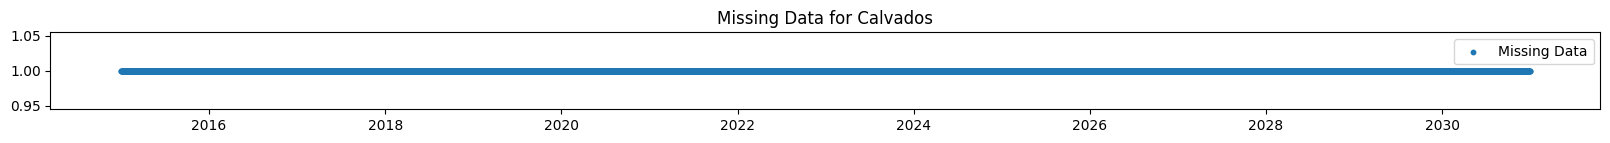

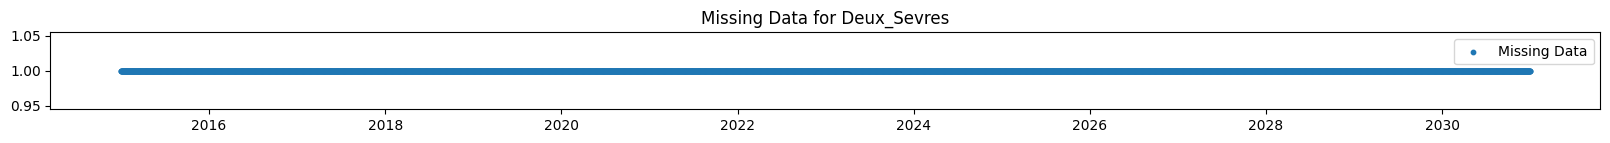

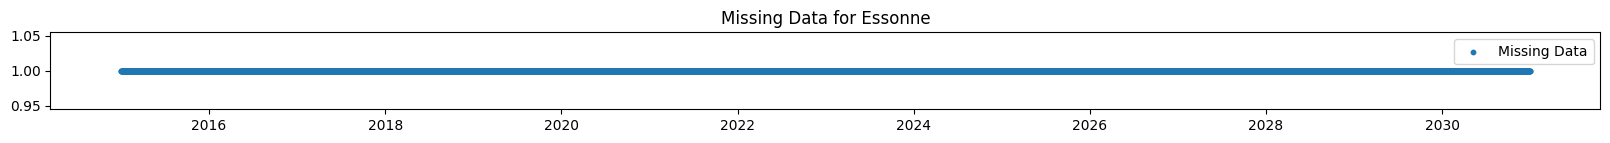

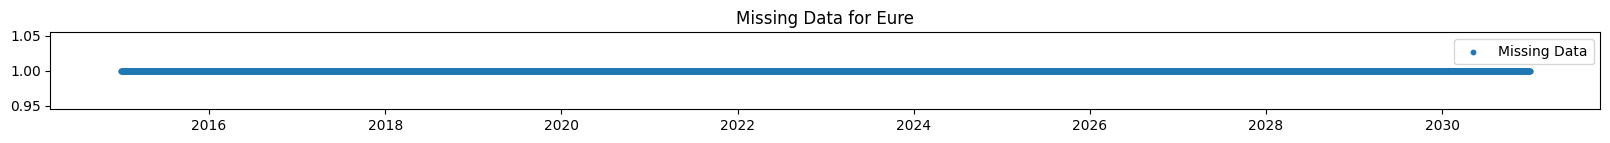

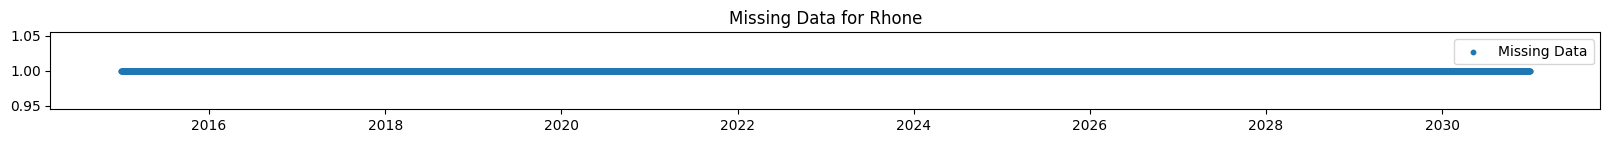

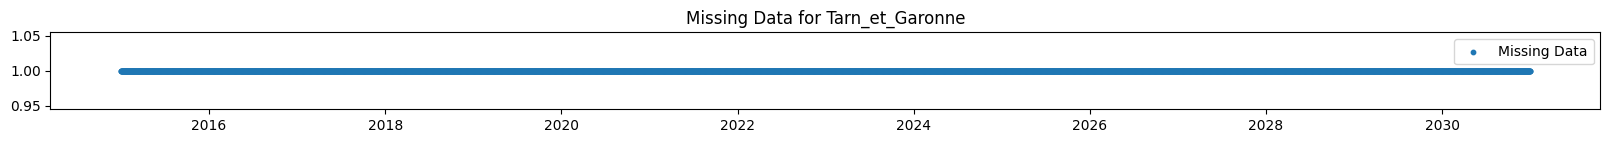

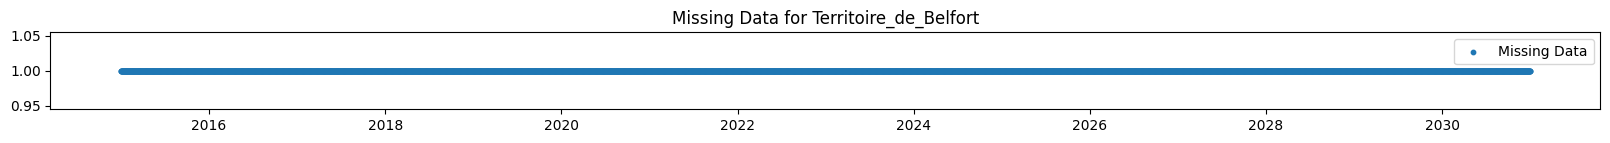

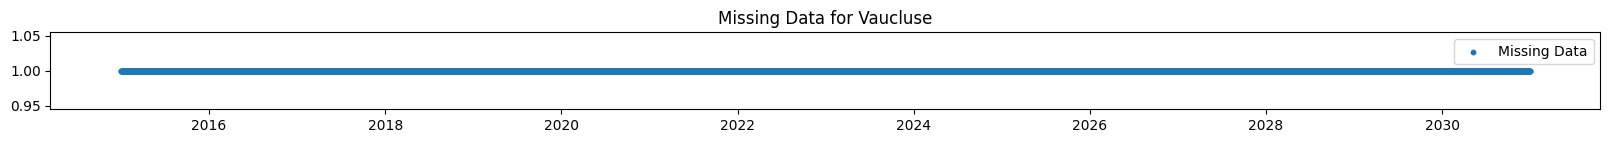

In [ ]:
for departement in missing_dep:
    missing_flag = (
        df_climate[
            (df_climate["nom_dep"] == departement)
            & (df_climate["scenario"] == missing_scenario[0])
        ]["precipitation"]
        .isna()
        .astype(int)
    )
    first_missing = missing_flag[missing_flag == 1].index[0]
    last_missing = missing_flag[missing_flag == 1].index[-1]
    missing_flag = missing_flag.loc[first_missing:last_missing]
    plt.figure(figsize=(20, 1))
    plt.scatter(missing_flag.index, missing_flag, s=10)
    plt.legend(["Missing Data"])
    plt.title(f"Missing Data for {departement}")
    plt.show()

#### Conclusion on missing data

We have only one scenario concerned by missing data :

- ssp2_4_5

The only departments concerned by missing data are :

- 'Calvados'
- 'Deux_Sevres'
- 'Essonne'
- 'Eure'
- 'Rhone'
- 'Tarn_et_Garonne'
- 'Territoire_de_Belfort'
- 'Vaucluse'

For each of these departments, the absence of data is complete : we do not have any data for the whole period.


#### Data imputation for missing data


Our strategy will depend on:

- The performance (yield) of the concerned department
- The number of data points
- The complexity of imputing the missing data (department proximity, other data...)


In [ ]:
# TODO and Discuss with the team

#### Dataset creation


In [ ]:
df_climate_hist = df_climate[df_climate["scenario"] == "historical"]
df_climate_ssp126 = df_climate[df_climate["scenario"] == "ssp1_2_6"]
df_climate_ssp245 = df_climate[df_climate["scenario"] == "ssp2_4_5"]
df_climate_ssp585 = df_climate[df_climate["scenario"] == "ssp5_8_5"]
dfs = [df_climate_hist, df_climate_ssp126, df_climate_ssp245, df_climate_ssp585]
assert sum([len(df) for df in dfs]) == len(df_climate)
for df in dfs:
    assert (
        df.isna().sum().sum() == 0
    ), f'There are missing values in the "{df["scenario"].unique()}" scenario for the "{df[df.isna().any(axis=1)]['nom_dep'].unique()}" department'

AssertionError: There are missing values in the "['ssp2_4_5']" scenario for the "['Calvados' 'Deux_Sevres' 'Essonne' 'Eure' 'Rhone' 'Tarn_et_Garonne'
 'Territoire_de_Belfort' 'Vaucluse']" department

#### Visualization


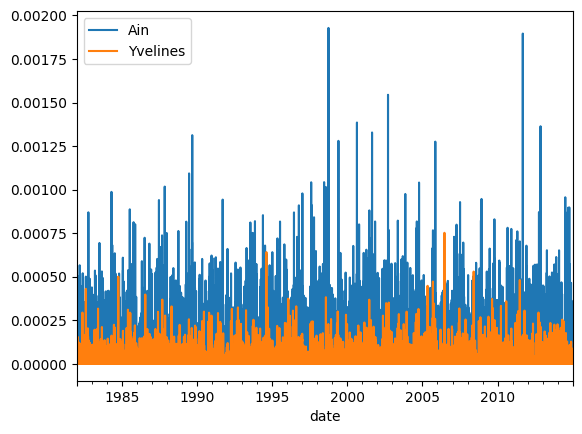

In [158]:
df_climate_hist[df_climate_hist["nom_dep"].isin(["Ain", "Yvelines"])].groupby(
    ["nom_dep"]
)["precipitation"].plot(legend=True)
plt.show()

# Yield DataFrame


In [8]:
df_yield

,department,year,yield,area,production
0,Ain,1982,3.95008,16065.0,63458.00
1,Ain,1983,NaN,14500.0,38400.00
2,Ain,1984,4.82258,15500.0,74750.00
3,Ain,1985,4.19677,15500.0,65050.00
4,Ain,1986,3.59845,12900.0,46420.00
...,...,...,...,...,...
3578,Yvelines,2014,7.70000,10180.0,78546.00
3579,Yvelines,2015,8.00000,11420.0,91400.50
3580,Yvelines,2016,NaN,12225.0,64792.50
3581,Yvelines,2017,7.31000,13735.0,100402.85


In [16]:
df_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3583 entries, 0 to 3582
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   department  3583 non-null   object 
 1   year        3583 non-null   int64  
 2   yield       3336 non-null   float64
 3   area        3468 non-null   float64
 4   production  3461 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 140.1+ KB


In [ ]:
df_yield = df_yield.set_index("year", drop=True)
df_yield

,department,yield,area,production
year,,,,
1982,Ain,3.95008,16065.0,63458.00
1983,Ain,NaN,14500.0,38400.00
1984,Ain,4.82258,15500.0,74750.00
1985,Ain,4.19677,15500.0,65050.00
1986,Ain,3.59845,12900.0,46420.00
...,...,...,...,...
2014,Yvelines,7.70000,10180.0,78546.00
2015,Yvelines,8.00000,11420.0,91400.50
2016,Yvelines,NaN,12225.0,64792.50


#### Missing data


In [160]:
df_yield.isna().sum()

department      0
year            0
yield         247
area          115
production    122
dtype: int64

In [166]:
missing_yield = df_yield[df_yield.isna().any(axis=1)]
missing_yield

,department,year,yield,area,production
1,Ain,1983,NaN,14500.0,38400.0
16,Ain,1998,NaN,9500.0,60050.0
39,Aisne,1984,NaN,53500.0,382450.0
169,Alpes_Maritimes,2003,NaN,55.0,137.5
187,Ardeche,1984,NaN,4057.0,19658.0
...,...,...,...,...,...
3497,Vosges,2007,NaN,12150.0,52140.0
3506,Vosges,2016,NaN,11950.0,55448.0
3525,Yonne,1998,NaN,58857.0,393515.8
3543,Yonne,2016,NaN,79315.0,372780.5


In [ ]:
df_yield[df_yield["area"].isna()]

,department,year,yield,area,production
439,Bas_Rhin,2014,NaN,NaN,NaN
440,Bas_Rhin,2015,NaN,NaN,NaN
727,Corse_du_Sud,2006,NaN,NaN,NaN
728,Corse_du_Sud,2007,NaN,NaN,NaN
729,Corse_du_Sud,2008,NaN,NaN,NaN
...,...,...,...,...,...
3097,Seine_SeineOise,2011,NaN,NaN,NaN
3098,Seine_SeineOise,2012,NaN,NaN,NaN
3099,Seine_SeineOise,2013,NaN,NaN,NaN
3100,Seine_SeineOise,2014,NaN,NaN,NaN


#### Conclusion on missing data


#### Visualisation


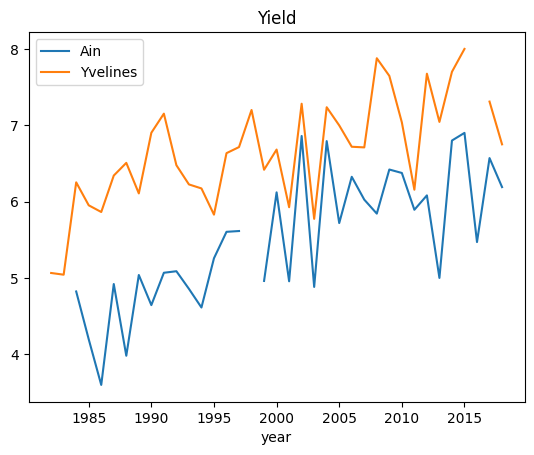

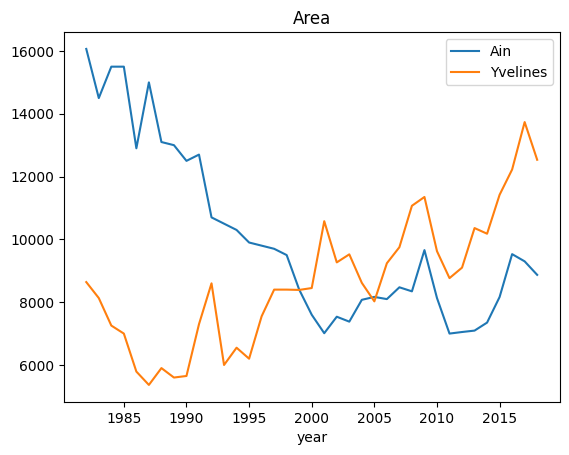

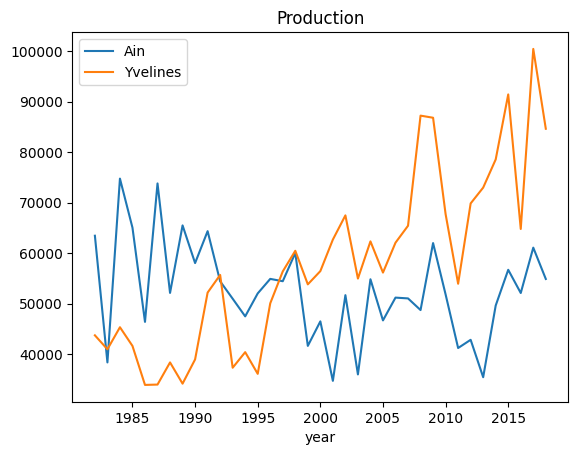

In [ ]:
df_yield[df_yield["department"].isin(["Ain", "Yvelines"])].groupby(["department"])[
    "yield"
].plot(legend=True, title="Yield")
plt.show()
df_yield[df_yield["department"].isin(["Ain", "Yvelines"])].groupby(["department"])[
    "area"
].plot(legend=True, title="Area")
plt.show()
df_yield[df_yield["department"].isin(["Ain", "Yvelines"])].groupby(["department"])[
    "production"
].plot(legend=True, title="Production")
plt.show()